In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import missingno as msno
import seaborn as sns
from datetime import date,datetime
import os
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Model selection and evaluation tools
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, matthews_corrcoef, recall_score
from sklearn.metrics import precision_score, average_precision_score, f1_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier

# Data processing
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [4]:
import sys
sys.path.insert(0, './')
from ds_toolbox import plot_coefficients, plot_roc_curve, plot_roc_curves, plot_confusion_matrix, plot_histograms
from ds_toolbox import plot_conditional_distributions, classifier_metric_report, classifiers_metric_report
from ds_toolbox import plot_roc_curves_with_classifiers
from ds_toolbox import create_balanced_dataset, plot_feature_importance, plot_confusion_matrix
from ds_toolbox import plot_confusion_matrix_with_labels, plot_recall_curve

In [5]:
# checking the current directory
os.getcwd()

'/Users/yg/code/github/data-challenges/DC-1'

# Cookie Purchase Analysis

* Business objectives:
    * Based on web traffic information, predict future purchase of a cookie.
    
* Technical objectives:
  - Create at least two different classes of models (e.g. logistic regression, random forest, etc.) to classify these cookies into future buyers or not. 
  - Explain your choice of model.
  - How did you do model selection? 
  - How you validated the quality of the model?
  - Which variables are most informative of purchase. 
  - Comment on any general trends or anomalies in the data you can identify.
  - Propose a meaning for those fields not defined:
      expected_time_buy - expected_time_visit - multiple_buy - multiple_visit.

* Deliverables:
    -  A document with text and figures illustrating your thought process:
        how you began to explore the data, and a comparison of the models that you created. 
    - As a supplementary deliverable, please also submit your code, in a separate file from your write up.

1. [Data Wrangling](#Wrangle)
    1. [Read The Data](#Read)
2. [EDA](#EDA)
    1. [Class Imbalance](#ClassImbalance)
    2. [Visual Inspection Of Features](#VizFeatures)
        1. [Principal Component Analysis](#PCA)
        2. [Mean Correlation](#MeanCorr)
        3. [Distribution Plots](#DistPlots)
        4. [Unknown Variable Interpretation](#UnkVarInt)
3. [Modeling](#Modeling)
    1. [Modeling With Imbalanced Data Set](#ModelingImDataSet)
        1. [Logistic Regression](#ImDataSetLogIt)
        2. [Support Vector Machines](#ImDataSVM)
           1. [Linear Support Vector Classifier](#ImDataLinSVC)
        3. [Non-Ensemble Models: Model Evaluation](#ImDataLinModelEva)
        4. [Ensemble Models](#ImDataEnsModels)
            1. [Random Forest Classifier](#ImDataRF)
            2. [Gradient Boosting Classifier](#ImDataGB)
            3. [Ensemble classifiers Including Balancing Samplers](#ImDataEnsSampModels)
                1. [Balanced Bagging Classifier](#ImDataBalBag)
                2. [Balanced Random Forrest Classifier](#ImDataBalRF)
                3. [RUSBoostClassifier](#ImDataRUBoost)
            4.  [Ensemble Models: Model Evaluation](#ImDataEnsModelEva)
    2. [Imbalanced Classes Processing](#ImDataSetProcessing)
        1. [Try Downsampling](#DownSampling)
        2. [Try Upsampling](#UpSampling)
        3. [Using SMOTE Sampling Methods](#SMOTE)
            1. [ADASYN](#ADASYN)
            2. [SMOTE](#SMOTE)
    3. [Modeling With Balanced Data Set](#ModelingBalDataSet)
       1. [Modeling With Ensemble Classifiers Including Classifiers With Balancing Samplers](#BalDataEnsModels)
4. [Most Important Features](#MostImportantFeatures)
5. [Conclusion](#Conclusion)

# Data Wrangling <a name="Wrangle"></a>
## Read In The Data <a name="Read"></a>

In [6]:
col_names =['isbuyer','buy_freq','visit_freq','buy_interval','sv_interval','expected_time_buy','expected_time_visit','last_buy','last_visitmultiple_buy','multiple_visit','uniq_urls','num_checkins','y_buy']
df = pd.read_csv('cleaned_data.csv')
print('Number of rows:',len(df))
df.head()

Number of rows: 54584


,Unnamed,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
0,NaN,0,NaN,1,0.0,0.0,0.0,0.0000,106,106,0,0,169,2130,0
1,NaN,0,NaN,1,0.0,0.0,0.0,0.0000,72,72,0,0,154,1100,0
2,NaN,0,NaN,1,0.0,0.0,0.0,0.0000,5,5,0,0,4,12,0
3,NaN,0,NaN,1,0.0,0.0,0.0,0.0000,6,6,0,0,150,539,0
4,NaN,0,NaN,2,0.0,0.5,0.0,-101.1493,101,101,0,1,103,362,0


In [7]:
df.drop('Unnamed', axis=1, inplace=True)

In [8]:
df.dtypes

isbuyer                  int64
buy_freq               float64
visit_freq               int64
buy_interval           float64
sv_interval            float64
expected_time_buy      float64
expected_time_visit    float64
last_buy                 int64
last_visit               int64
multiple_buy             int64
multiple_visit           int64
uniq_urls                int64
num_checkins             int64
y_buy                    int64
dtype: object

In [9]:
df.head()

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
0,0,NaN,1,0.0,0.0,0.0,0.0000,106,106,0,0,169,2130,0
1,0,NaN,1,0.0,0.0,0.0,0.0000,72,72,0,0,154,1100,0
2,0,NaN,1,0.0,0.0,0.0,0.0000,5,5,0,0,4,12,0
3,0,NaN,1,0.0,0.0,0.0,0.0000,6,6,0,0,150,539,0
4,0,NaN,2,0.0,0.5,0.0,-101.1493,101,101,0,1,103,362,0


In [10]:
df.describe()

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
count,54584.000000,2327.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000
mean,0.042632,1.240653,1.852777,0.210008,5.825610,-0.198040,-10.210786,64.729335,64.729335,0.006357,0.277444,86.569343,720.657592,0.004635
std,0.202027,0.782228,2.921820,3.922016,17.595442,4.997792,31.879722,53.476658,53.476658,0.079479,0.447742,61.969765,1275.727306,0.067924
min,0.000000,1.000000,0.000000,0.000000,0.000000,-181.923800,-187.615600,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,18.000000,18.000000,0.000000,0.000000,30.000000,127.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,51.000000,51.000000,0.000000,0.000000,75.000000,319.000000,0.000000
75%,0.000000,1.000000,2.000000,0.000000,0.104167,0.000000,0.000000,105.000000,105.000000,0.000000,1.000000,155.000000,802.000000,0.000000
max,1.000000,15.000000,84.000000,174.625000,184.916700,84.285710,91.401920,188.000000,188.000000,1.000000,1.000000,206.000000,37091.000000,1.000000


In [11]:
continuous = ['buy_freq','visit_freq','buy_interval','sv_interval','expected_time_buy','expected_time_visit','last_buy','last_visit','uniq_urls','num_checkins']
print(len(continuous))

10


In [12]:
df['isbuyer'].value_counts()

0    52257
1     2327
Name: isbuyer, dtype: int64

In [13]:
df['multiple_visit'].value_counts()

0    39440
1    15144
Name: multiple_visit, dtype: int64

In [14]:
df['multiple_buy'].value_counts()

0    54237
1      347
Name: multiple_buy, dtype: int64

In [15]:
df['y_buy'].value_counts()

0    54331
1      253
Name: y_buy, dtype: int64

The data does not have unexpected values or outliers.

In [16]:
feature_names = list(df.columns.values[:-1])
feature_names

['isbuyer',
 'buy_freq',
 'visit_freq',
 'buy_interval',
 'sv_interval',
 'expected_time_buy',
 'expected_time_visit',
 'last_buy',
 'last_visit',
 'multiple_buy',
 'multiple_visit',
 'uniq_urls',
 'num_checkins']

In [17]:
print("Percent of missing data per column:")
100*df.isna().sum()/len(df)

Percent of missing data per column:


isbuyer                 0.000000
buy_freq               95.736846
visit_freq              0.000000
buy_interval            0.000000
sv_interval             0.000000
expected_time_buy       0.000000
expected_time_visit     0.000000
last_buy                0.000000
last_visit              0.000000
multiple_buy            0.000000
multiple_visit          0.000000
uniq_urls               0.000000
num_checkins            0.000000
y_buy                   0.000000
dtype: float64

'buy_freq' column is barely populated (5%).

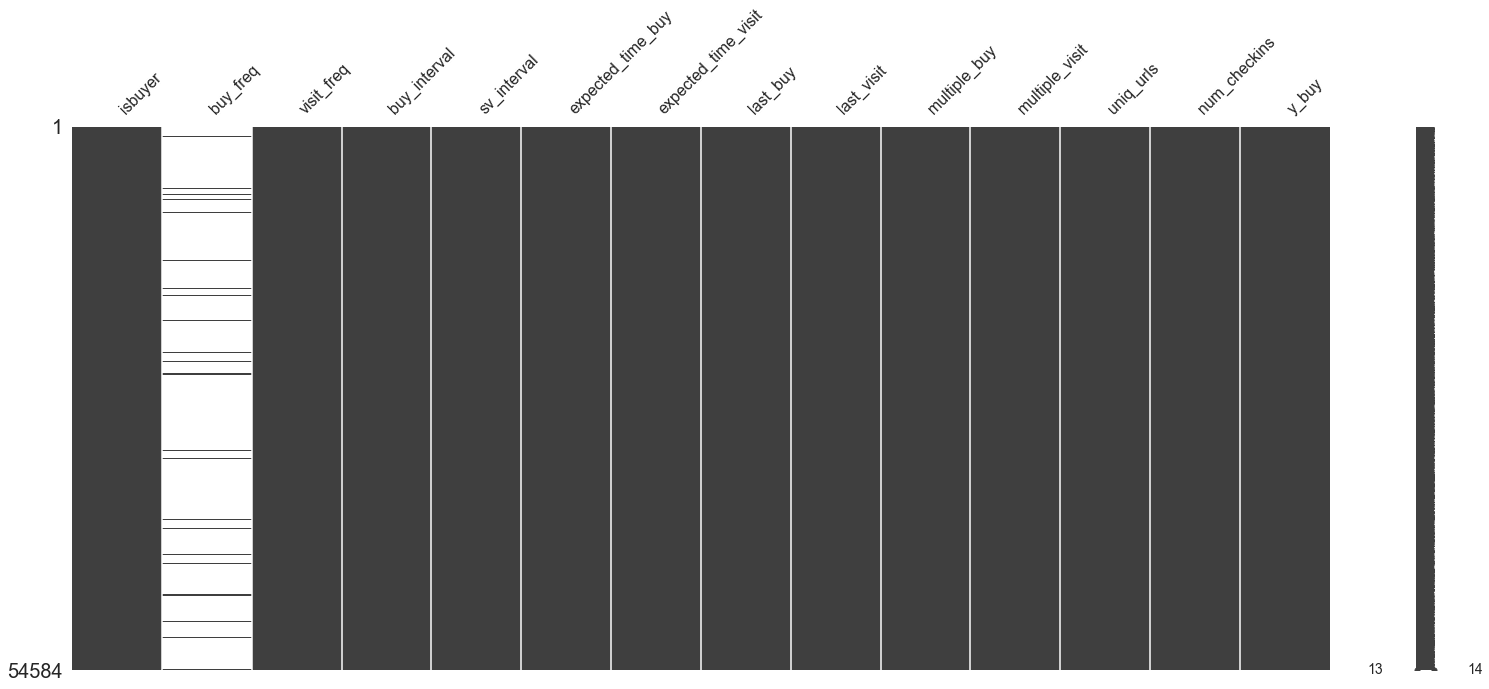

In [18]:
msno.matrix(df);

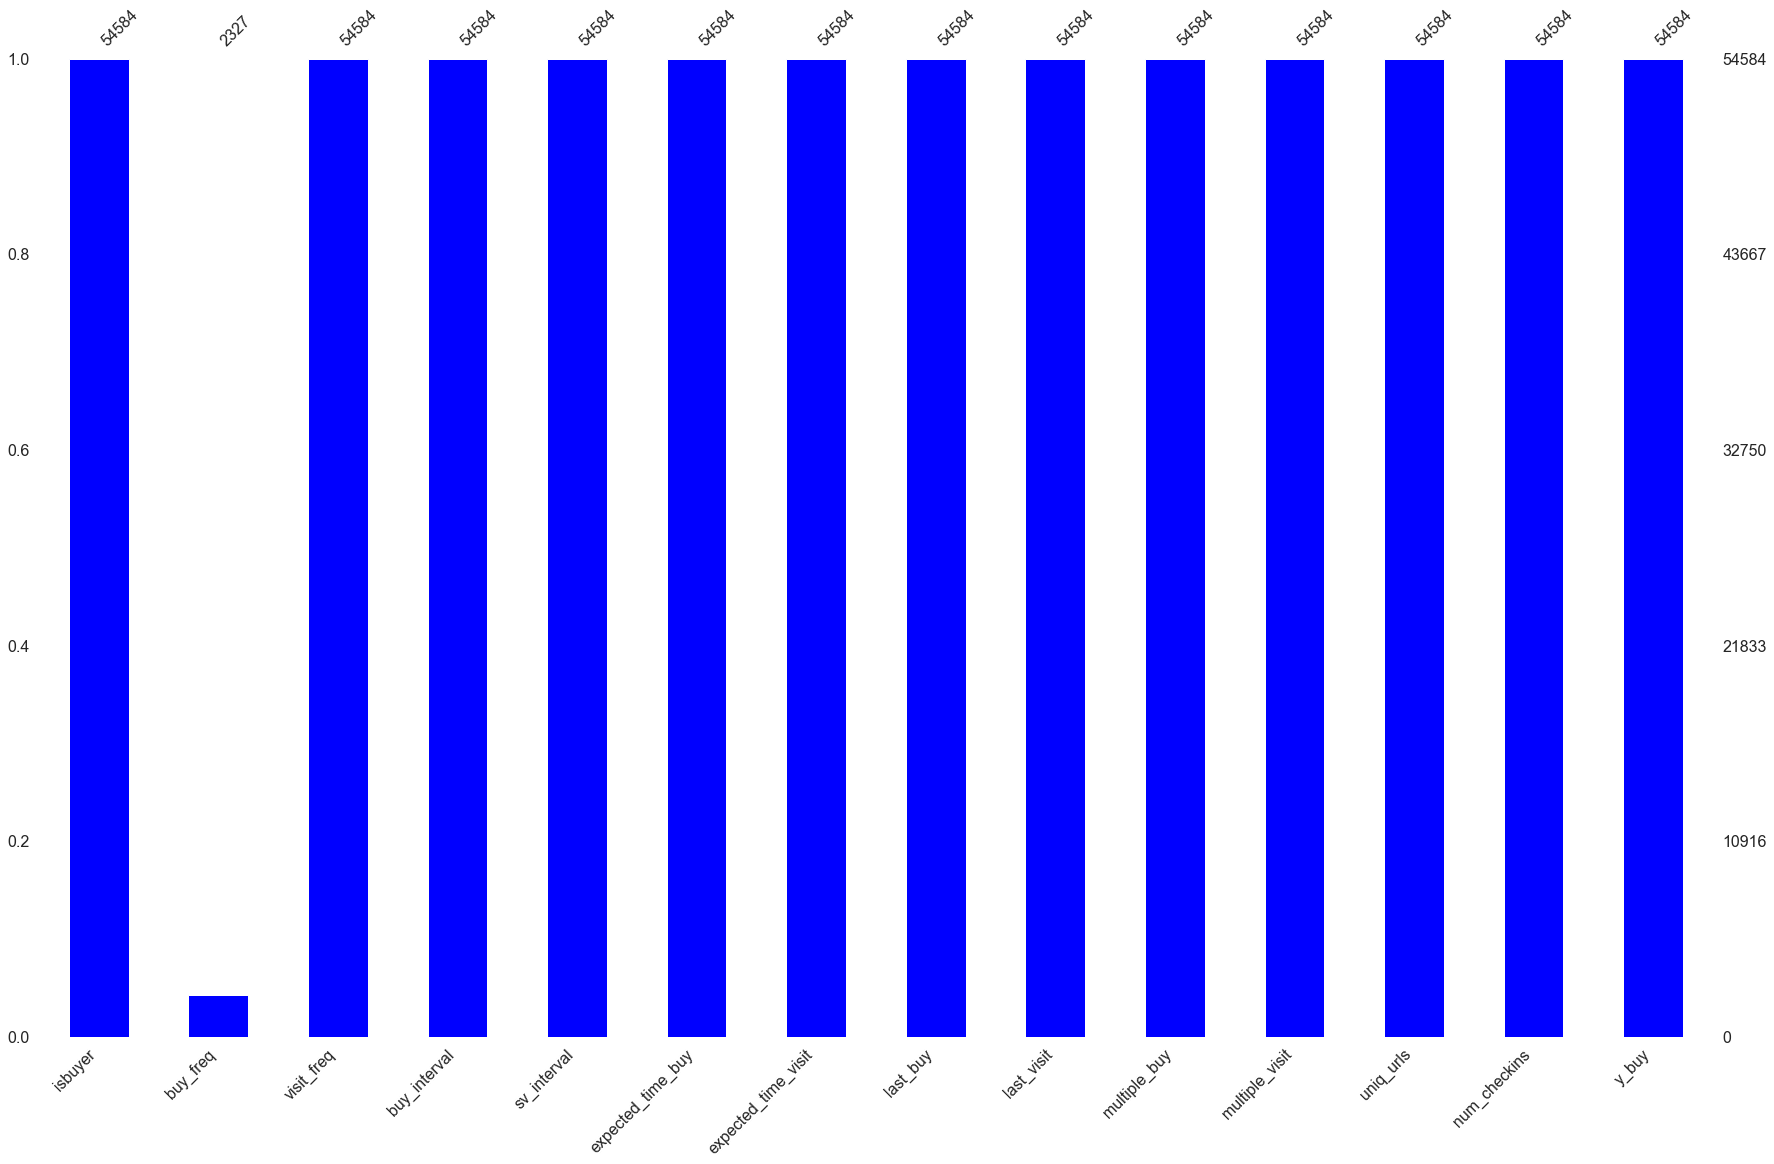

In [19]:
msno.bar(df, color="blue", figsize=(30,18));

Most of the data is not missing except the 'buy_freq' column .
We notice that we have a past buyer (isbuyer=1) then the cookie is a frequent buyer ([1,15]).
We can populate the missing values for this column with 0 whenever it was not a buyer (isbuyer=0).

In [20]:
df['buy_freq'] = df.apply(lambda row: 0 if (np.isnan(row['buy_freq']) and row['isbuyer'] == 0) else row['buy_freq'], 
                                      axis=1)

In [21]:
print("Percent of missing data per column:")
100*df.isna().sum()/len(df)

Percent of missing data per column:


isbuyer                0.0
buy_freq               0.0
visit_freq             0.0
buy_interval           0.0
sv_interval            0.0
expected_time_buy      0.0
expected_time_visit    0.0
last_buy               0.0
last_visit             0.0
multiple_buy           0.0
multiple_visit         0.0
uniq_urls              0.0
num_checkins           0.0
y_buy                  0.0
dtype: float64

# EDA <a name="EDA"></a>

## Class Imbalance <a name="ClassImbalance"></a>

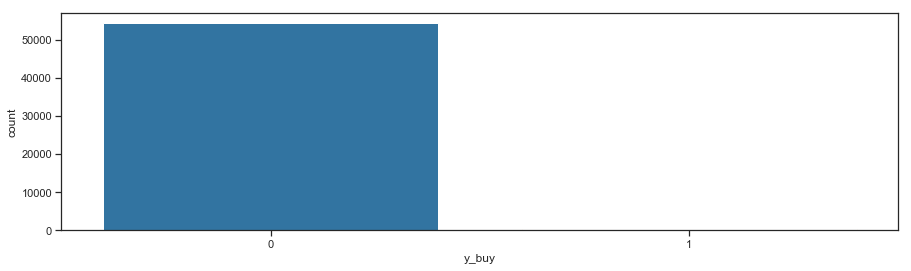

In [22]:
plt.figure(figsize=(15,4))
sns.countplot(df['y_buy']);

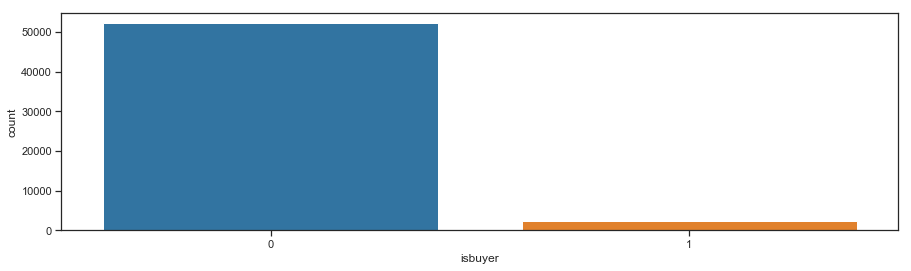

In [23]:
plt.figure(figsize=(15,4))
sns.countplot(df['isbuyer']);

In [24]:
#look at class distribution (percentages)
print('Class percentages')
print('-'*50)
df['y_buy'].value_counts()/len(df['y_buy'])*100

Class percentages
--------------------------------------------------


0    99.536494
1     0.463506
Name: y_buy, dtype: float64

## Very Imbalanced data set regarding the target variable: y_buy.
## isBuyer and y_buy variables are imbalanced in about the same proportion.

In [25]:
# Let's replace the Class Variable by a boolean (True if it is a future buyer)
df['FutureBuyer'] = False
df['FutureBuyer'][df['y_buy']==1]=True

## Visual Inspection Of Features <a name="VizFeatures"></a>

### Principal Component Analysis <a name="PCA"></a>

In [26]:
scaled_features = StandardScaler().fit_transform(df[df.columns[:-2].values])
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns[:-2])

In [27]:
n_components = 10

pca = PCA(n_components=n_components)

principal_components = pca.fit_transform(scaled_features)

principal_dataframe = pd.DataFrame(data=principal_components)
                                  #columns=['component 1', 'component 2'])

principal_dataframe_labeled = pd.concat([principal_dataframe,
                                         df[['FutureBuyer']]],
                                         axis=1)

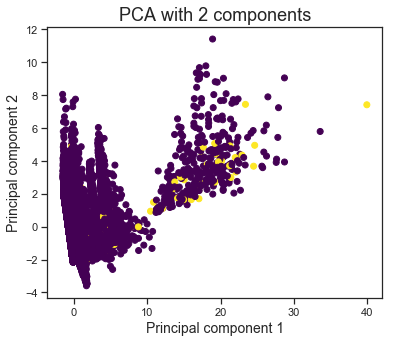

In [28]:
plt.figure(figsize=(6,5))

plt.scatter(principal_dataframe_labeled[0],
           principal_dataframe_labeled[1],
           c = principal_dataframe_labeled['FutureBuyer'],
           cmap = 'viridis')

plt.xlabel('Principal component 1', fontsize=14)
plt.ylabel('Principal component 2', fontsize=14)

plt.title('PCA with 2 components', fontsize=18);
# plt.savefig(r'pca_two_components.pdf', bbox_inches='tight', transparent=True);

In [29]:
for i in range(n_components):
    print('Principal Component {}: {:0.2f}% of explained variance'\
          .format(i, 100 * pca.explained_variance_ratio_[i]))
    

Principal Component 0: 25.30% of explained variance
Principal Component 1: 17.85% of explained variance
Principal Component 2: 13.62% of explained variance
Principal Component 3: 9.77% of explained variance
Principal Component 4: 7.72% of explained variance
Principal Component 5: 7.15% of explained variance
Principal Component 6: 6.24% of explained variance
Principal Component 7: 4.87% of explained variance
Principal Component 8: 4.30% of explained variance
Principal Component 9: 1.48% of explained variance


9 important predictors. 

### Mean Correlation <a name="MeanCorr"></a>

In [30]:
# Standardize features to [0,1]
scaled_features = MinMaxScaler().fit_transform(df[df.columns.values])
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
scaled_features_df.describe()

,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy,FutureBuyer
count,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000,54584.000000
mean,0.042632,0.003526,0.022057,0.001203,0.031504,0.682642,0.635820,0.344305,0.344305,0.006357,0.277444,0.423040,0.019403,0.004635,0.004635
std,0.202027,0.019877,0.034784,0.022460,0.095153,0.018774,0.114257,0.284450,0.284450,0.079479,0.447742,0.299371,0.034395,0.067924,0.067924
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.011905,0.000000,0.000000,0.683386,0.672415,0.095745,0.095745,0.000000,0.000000,0.149758,0.003397,0.000000,0.000000
50%,0.000000,0.000000,0.011905,0.000000,0.000000,0.683386,0.672415,0.271277,0.271277,0.000000,0.000000,0.367150,0.008574,0.000000,0.000000
75%,0.000000,0.000000,0.023810,0.000000,0.000563,0.683386,0.672415,0.558511,0.558511,0.000000,1.000000,0.753623,0.021596,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


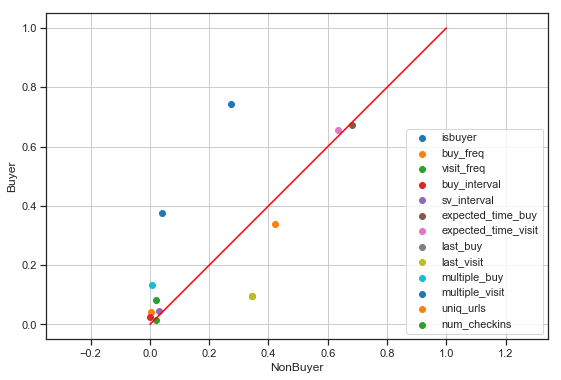

In [31]:
fig, ax = plt.subplots()
ax.plot([0,1],[0,1],'-r')
input_columns = scaled_features_df.columns[:-2]
mean_dict = dict()
for column in input_columns:
    mean_dict[column] = dict()
    for class_ in [0.,1.]:
        mean_dict[column][class_] = scaled_features_df[scaled_features_df.y_buy==class_][column].mean()
    ax.scatter(mean_dict[column][0],mean_dict[column][1],label=column)
ax.legend()
plt.xlabel('NonBuyer')
plt.ylabel('Buyer')
ax.axis('equal')
ax.grid(True)
# plt.savefig(r'mean_correlation.pdf', bbox_inches='tight', transparent=True)

At first it seems  these features will be good predictors:
- isBuyer
- multiple_visits
- last_visit
- multiple_buy
- uniq_urls

### Distribution Plots <a name="DistPlots"></a>

In [32]:
#stratify split based on target 'FutureBuyer'
index_train, index_test  = train_test_split(np.array(df.index), 
                                            stratify=df['FutureBuyer'], 
                                            test_size=0.25,random_state=10)

train = df.loc[index_train,:].copy()
test =  df.loc[index_test,:].copy()

# The response is the FutureBuyer variable (1 if buyer, 0 if not)

y_train = train['y_buy']
y_test = test['y_buy']

#compare value count of original data
print('Training size:', train.shape[0])
print('Test size:', test.shape[0])

Training size: 40938
Test size: 13646


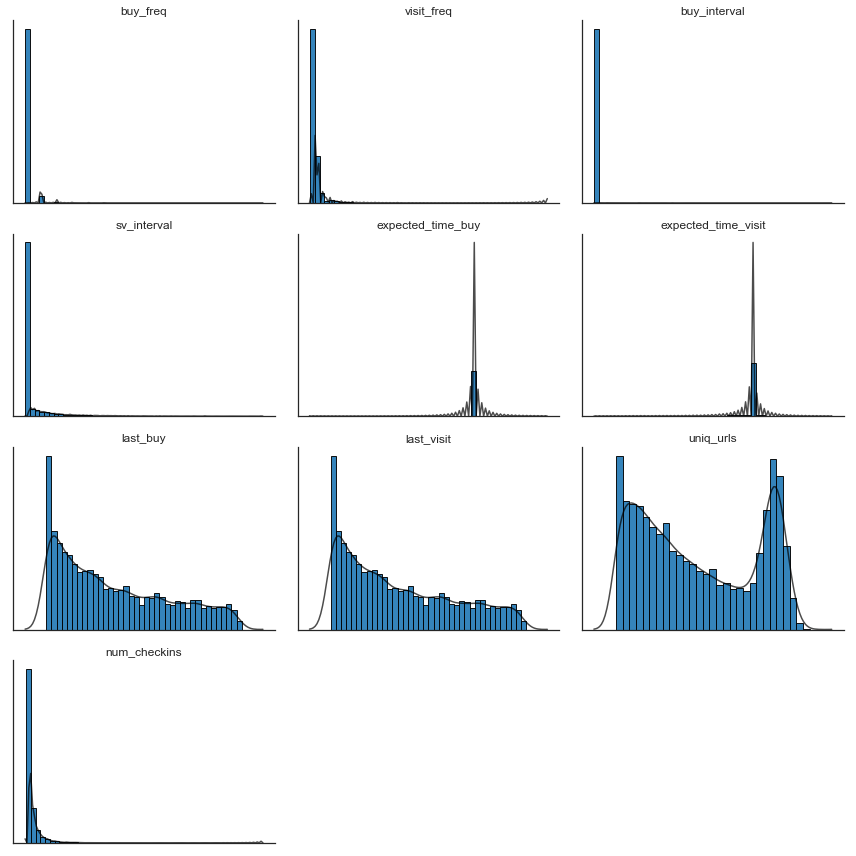

In [33]:
plot_histograms(train[continuous]);
# plt.savefig(r'distribution_plots.pdf', bbox_inches='tight', transparent=True);

In [34]:
table = pd.DataFrame(train[continuous].skew().round(2), columns=['Skewness'])
table['Kurtosis'] = train[continuous].kurt().round(2)
table

,Skewness,Kurtosis
buy_freq,11.94,295.81
visit_freq,9.52,139.60
buy_interval,24.96,750.36
sv_interval,4.71,27.13
expected_time_buy,-21.57,614.77
expected_time_visit,-2.90,9.02
last_buy,0.61,-0.82
last_visit,0.61,-0.82
uniq_urls,0.20,-1.45
num_checkins,7.50,112.79


The distribution plots suggest that most predictors are positively skewed, 
to the exception of expected_time_buy and expected_time_visit.

In [35]:
predicted_class_names = ['NonBuyer','Buyer']

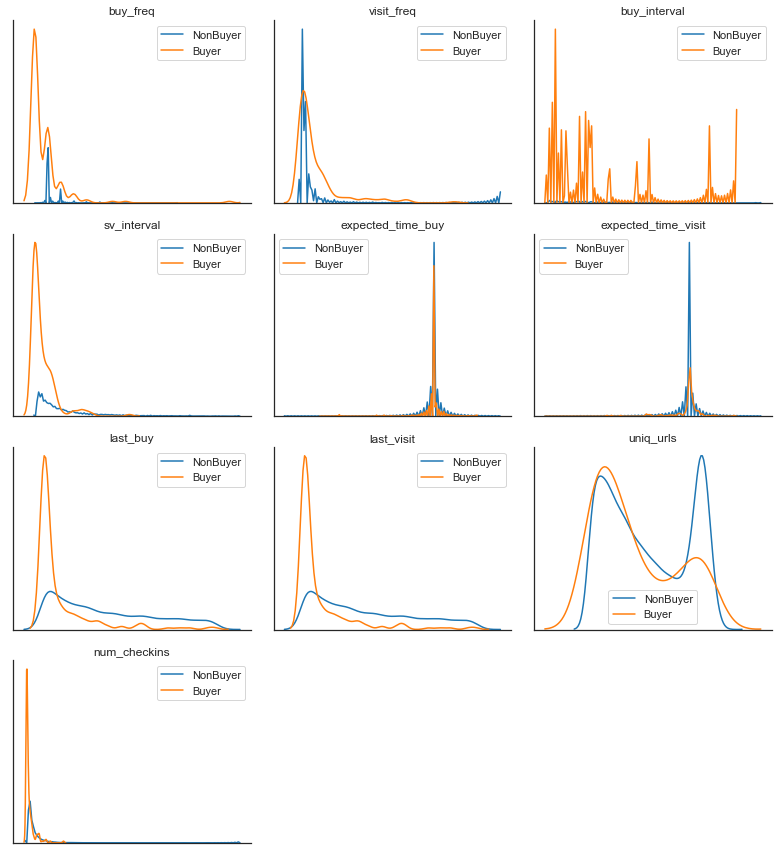

In [36]:
plot_conditional_distributions(train[continuous], y_train, labels=predicted_class_names);
#plt.savefig(r'conditional_distribution_plots.pdf', bbox_inches='tight', transparent=True);

It seems that most of the "continuous" predictors separate well buyer vs non buyer except:
    - buy_interval
    - expected_time_to_buy
    - expected_time_to_visit

### Unknown Variable Interpretation <a name="UnkVarInt"></a>

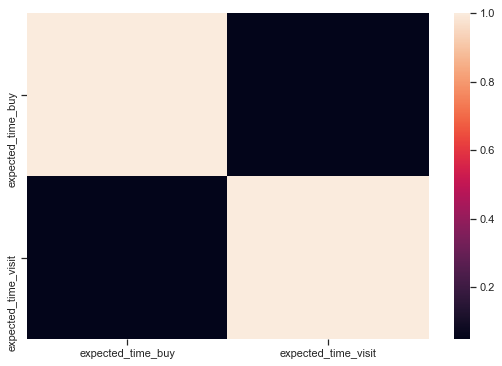

In [37]:
unknown_variable_columns = ['expected_time_buy', 'expected_time_visit']
cormat = train[unknown_variable_columns].corr()
sns.heatmap(cormat, xticklabels=cormat.columns.values,yticklabels=cormat.columns.values);

In [38]:
cormat

,expected_time_buy,expected_time_visit
expected_time_buy,1.000000,0.047982
expected_time_visit,0.047982,1.000000


No correlations at all between these two features.

In [39]:
candidate_columns = ['isbuyer','buy_freq','buy_interval','sv_interval','expected_time_buy','last_buy']
print(len(candidate_columns))

6


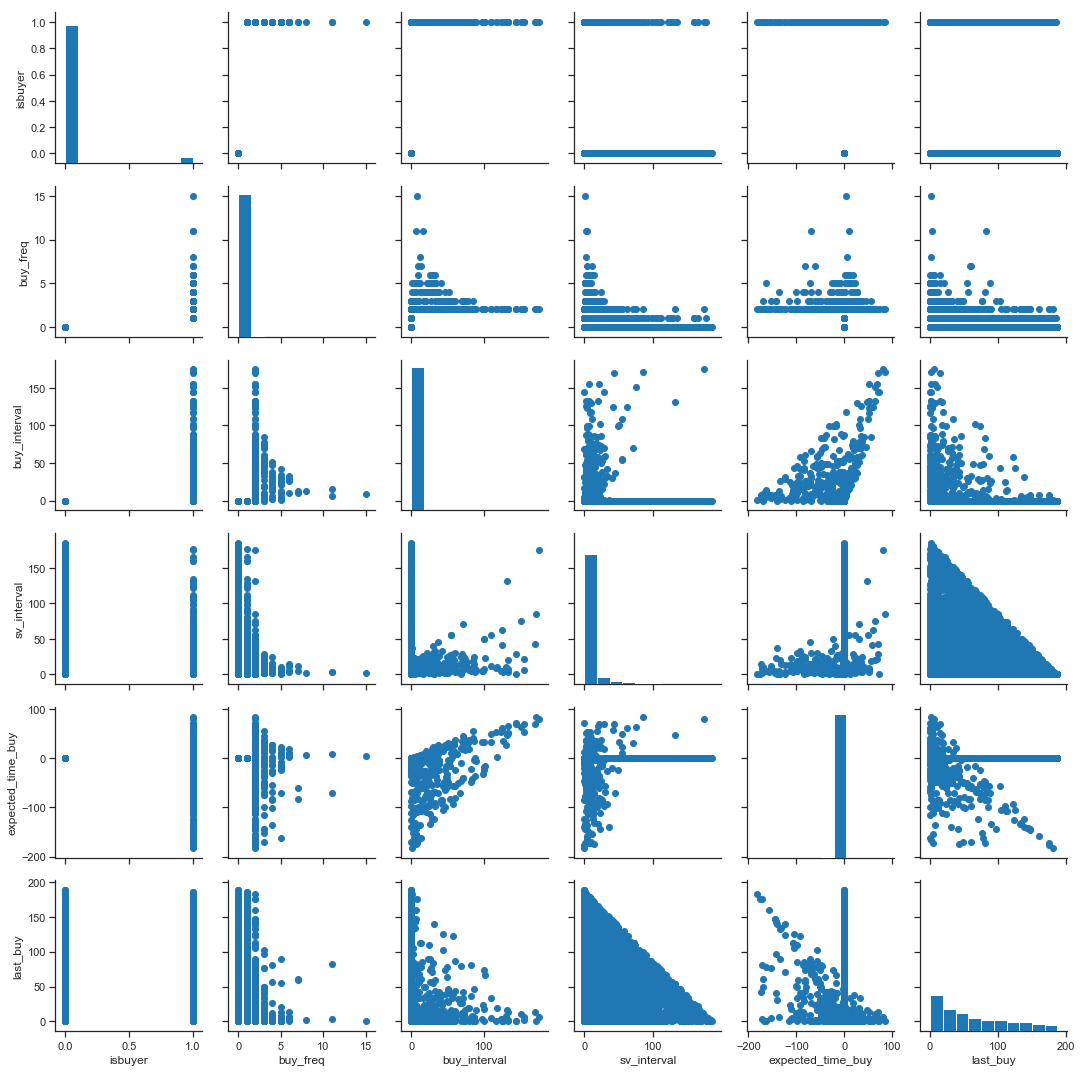

In [40]:
g = sns.PairGrid(df[candidate_columns])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

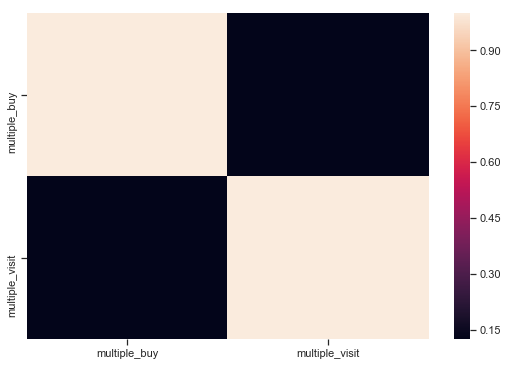

In [41]:
unknown_variable_columns = ['multiple_buy','multiple_visit']
cormat = train[unknown_variable_columns].corr()
sns.heatmap(cormat, xticklabels=cormat.columns.values,yticklabels=cormat.columns.values);

No correlation between multiple_buy and multiple_visit.

In [42]:
candidate_columns = ['visit_freq','sv_interval','multiple_visit','last_visit']
print(len(candidate_columns))

4


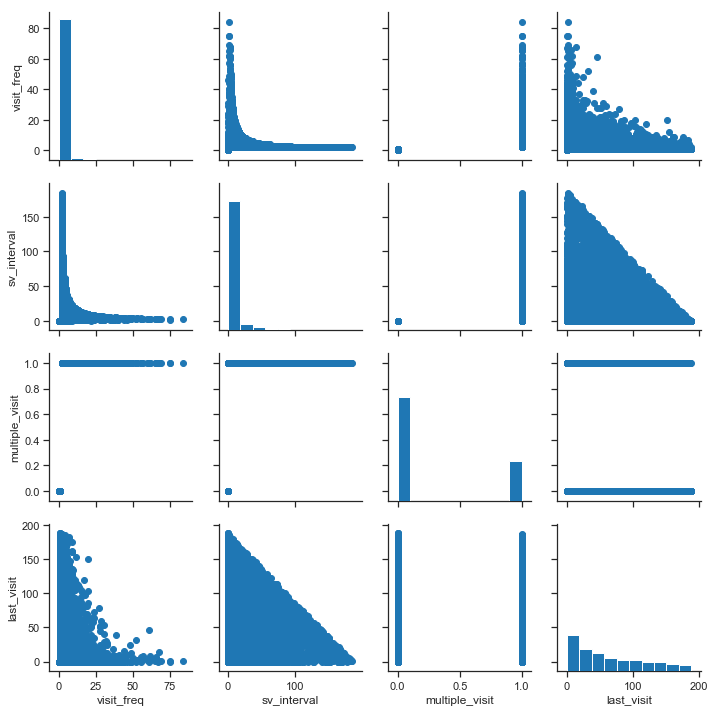

In [43]:
g = sns.PairGrid(df[candidate_columns])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

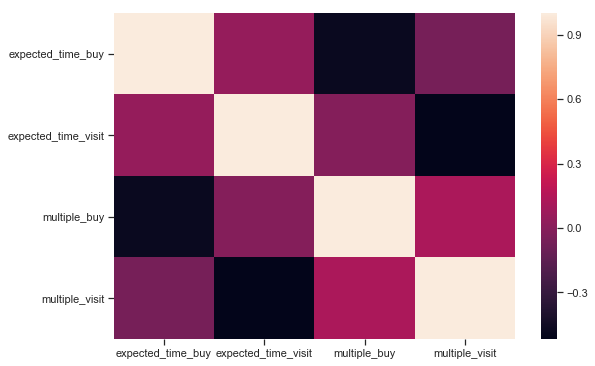

In [44]:
unknown_variable_columns = ['expected_time_buy','expected_time_visit','multiple_buy','multiple_visit']
cormat = train[unknown_variable_columns].corr()
sns.heatmap(cormat, xticklabels=cormat.columns.values,yticklabels=cormat.columns.values);

In [45]:
cormat

,expected_time_buy,expected_time_visit,multiple_buy,multiple_visit
expected_time_buy,1.000000,0.047982,-0.480222,-0.059027
expected_time_visit,0.047982,1.000000,-0.009024,-0.517797
multiple_buy,-0.480222,-0.009024,1.000000,0.125733
multiple_visit,-0.059027,-0.517797,0.125733,1.000000


Anti-correlations between (multiple_buy, expected_time_buy) and (multiple_visit, expected_time_visit).

* multiple_buy: if there was a buy (isBuyer=1) and buy_freq > 1.
* multiple_visit: if the visit_freq > 1.
* expected_time_to_buy: time to next purchase.
* expected_time_visit: time to the next visit.

In [46]:
df.drop('FutureBuyer', axis=1, inplace=True)

# Modeling <a name="Modeling"></a>

1. We need an interpretable model to address questions about feature importance in predicting a future purchase for a cookie.
2. We also need to consider that the targe class is imbalanced.

In [47]:
X = df[df.columns[:-1]]
y = df['y_buy']
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X.shape

(54584, 13)

## Modeling With Imbalanced Data Set <a name="ModelingImDataSet"></a>

### Logistic Regression <a name="ImDataSetLogIt"></a>

In [50]:
%%time
model = LogisticRegression()
#model = LogisticRegression(class_weight='balanced')
tuning_parameters = {
    'C':np.logspace(-5,5,11),
    'class_weight':['balanced',None],
    'penalty':['l1','l2']
}

lr_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 5, return_train_score=False, n_jobs=4,
                              random_state = 20)
lr_search.fit(X_train, y_train)
print('Best parameters:', lr_search.best_params_)
logit = lr_search.best_estimator_

Best parameters: {'penalty': 'l1', 'class_weight': None, 'C': 0.1}
CPU times: user 156 ms, sys: 37.7 ms, total: 193 ms
Wall time: 1.73 s


### Support Vector Machines <a name="ImDataSVM"></a>

#### Linear Support Vector Classifier <a name="ImDataLinSVC"></a>

In [51]:
%%time
# Linear SVC tuning with grid search cross validation

Cs = list(np.logspace(-5,5,11))
#Cs = list(np.logspace(-15, 15, 31, base=2))
model = Pipeline((
    #('scaler', StandardScaler()),
    ('clf', LinearSVC(loss='hinge')),
))

tuning_parameters ={
    'clf__C': Cs,
}

svm_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=4)
svm_search.fit(X_train, y_train)

print('Best parameter found by randomised search:', svm_search.best_params_, '\n')
svm_linear = svm_search.best_estimator_

Best parameter found by randomised search: {'clf__C': 1e-05} 

CPU times: user 262 ms, sys: 78.9 ms, total: 340 ms
Wall time: 1min 3s


### Non-Ensemble Models: Model Evaluation <a name="ImDataLinModelEva"></a>

In [52]:
labels=['Logistic regression', 'Linear SVC']
models=[logit, svm_linear]
scores = np.zeros((len(y_test), len(labels)))
for i, model in enumerate(models):
    scores[:,i] = model.decision_function(X_test)   

results = classifiers_metric_report(models, labels, X_test, y_test)
results.round(3)
#plt.savefig(r'imbalanced_dataset_logit_svc.pdf', bbox_inches='tight', transparent=True);

,Precision,Recall,F1-Score,Specificity
Logistic regression,0.0,0.996,0.995,1.0
Linear SVC,0.0,0.996,0.995,1.0


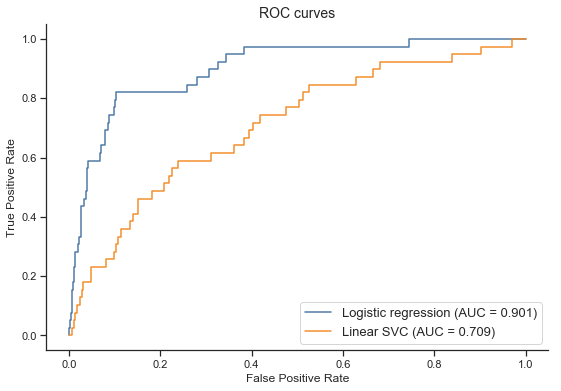

In [53]:
plot_roc_curves_with_classifiers(scores, y_test, labels);

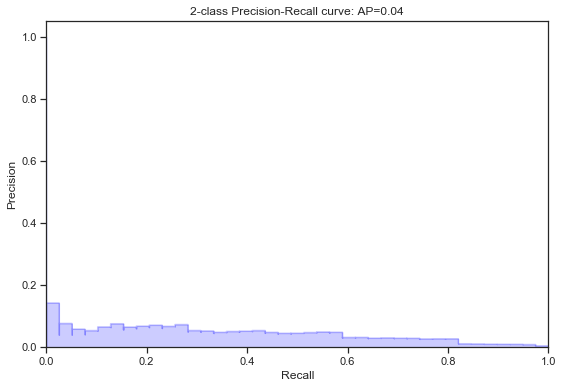

In [54]:
y_score = logit.decision_function(X_test)   
plot_recall_curve(y_test, y_score)

Lets' zoom in into detailed metrics.

In [55]:
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10878
           1       0.00      0.00      0.00        39

   micro avg       1.00      1.00      1.00     10917
   macro avg       0.50      0.50      0.50     10917
weighted avg       0.99      1.00      0.99     10917



Confusion matrix, without normalization


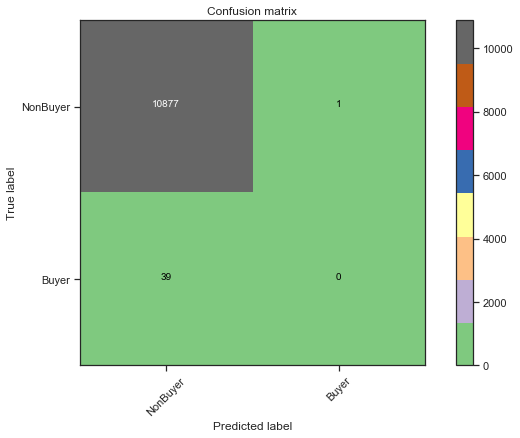

In [58]:
plot_confusion_matrix_with_labels(X_test, y_test, logit, predicted_class_names)

In [59]:
y_pred = svm_linear.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10878
           1       0.00      0.00      0.00        39

   micro avg       1.00      1.00      1.00     10917
   macro avg       0.50      0.50      0.50     10917
weighted avg       0.99      1.00      0.99     10917



Confusion matrix, without normalization


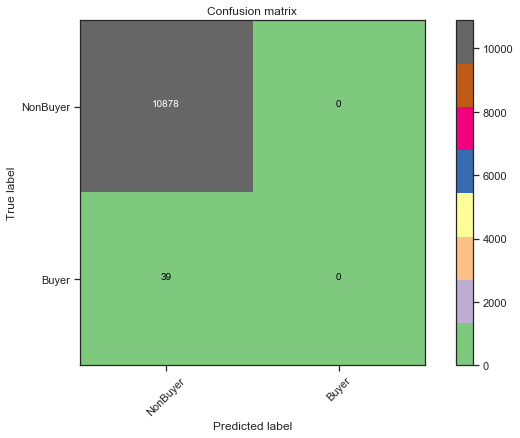

In [60]:
plot_confusion_matrix_with_labels(X_test, y_test, svm_linear, predicted_class_names);

We can do better...

### Ensemble Models <a name="ImDataEnsModels"></a>

#### Random Forest Classifier <a name="ImDataRF"></a>

In [61]:
%%time

model = RandomForestClassifier(n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 15, return_train_score=False, n_jobs=4,
                              random_state = 20)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 5, 'max_features': 1} 

CPU times: user 1.74 s, sys: 121 ms, total: 1.86 s
Wall time: 1min 9s


#### Gradient Boosting Classifier <a name="ImDataGB"></a>

In [62]:
%%time

model = GradientBoostingClassifier(n_estimators=100)

tuning_parameters = {
    'learning_rate': list(np.logspace(-5,5,11)),
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

gb_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, return_train_score=False, n_jobs=4,
                              random_state = 20)
gb_search.fit(X_train, y_train)

gb = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 50, 'max_features': 1, 'learning_rate': 0.001} 

CPU times: user 893 ms, sys: 124 ms, total: 1.02 s
Wall time: 18.2 s


#### Ensemble Classifiers Including Balancing Samplers  <a name="ImDataEnsSampModels"></a>

##### Balanced Bagging Classifier <a name="ImDataBalBag"></a>

In [63]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                #sampling_strategy='auto',
                replacement=False,
        random_state=0)
bbc.fit(X_train, y_train);

##### Balanced Random Forrest Classifier  <a name="ImDataBalRF"></a>

In [64]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train, y_train) ;

##### RUSBoostClassifier <a name="ImDataRUBoost"></a>

In [65]:
rusboost = RUSBoostClassifier(random_state=0)
rusboost.fit(X_train, y_train);  

### Ensemble Models: Model Evaluation <a name="ImDataEnsModelEva"></a>

In [66]:
labels=['Random Forest', 'Gradient Boosting', 'BalancedBaggingClassifier', 'BalancedRandomForestClassifier', 'RUSBoostClassifier']
models=[rf, gb, bbc, brf, rusboost]
scores = np.zeros((len(y_test), len(labels)))
for i, model in enumerate(models):
    scores[:,i] = model.predict_proba(X_test)[:,1]   

results = classifiers_metric_report(models, labels, X_test, y_test)
results.round(3)

,Precision,Recall,F1-Score,Specificity
Random Forest,0.000,0.996,0.995,1.000
Gradient Boosting,0.000,0.996,0.995,1.000
BalancedBaggingClassifier,0.019,0.873,0.929,0.873
BalancedRandomForestClassifier,0.016,0.816,0.895,0.816
RUSBoostClassifier,0.014,0.972,0.982,0.975


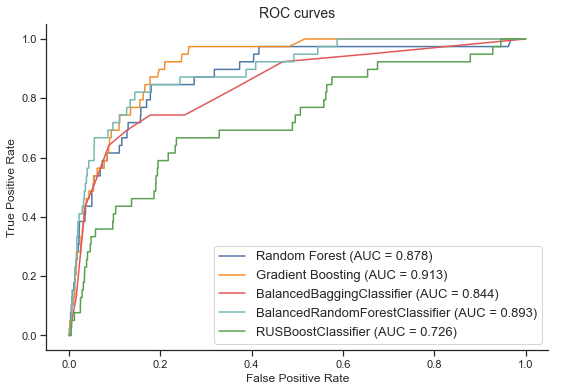

In [67]:
scores = np.zeros((len(y_test), len(models)))
for i, model in enumerate(models):
    scores[:,i] = model.predict_proba(X_test)[:,1]   
plot_roc_curves_with_classifiers(scores, y_test, labels);

In [68]:
# Get predicted probabilities
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10878
           1       0.00      0.00      0.00        39

   micro avg       1.00      1.00      1.00     10917
   macro avg       0.50      0.50      0.50     10917
weighted avg       0.99      1.00      0.99     10917



Confusion matrix, without normalization


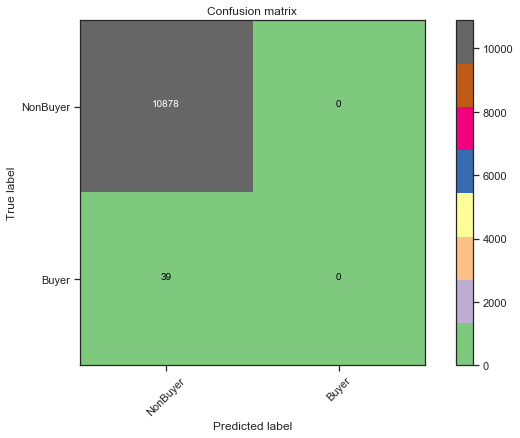

In [69]:
plot_confusion_matrix_with_labels(X_test, y_test, rf, predicted_class_names);

## Imbalanced Classes Processing <a name="ImDataSetProcessing"></a>

### Try Downsampling <a name="DownSampling"></a>

In [70]:
df['y_buy'].value_counts()

0    54331
1      253
Name: y_buy, dtype: int64

In [71]:
# Separate majority and minority classes

df_majority = df[df['y_buy']==0]
df_minority = df[df['y_buy']==1]    

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=253,    # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['y_buy'].value_counts()

1    253
0    253
Name: y_buy, dtype: int64

In [72]:
X_sampled = df_downsampled[df_downsampled.columns[:-1]]
scaler = StandardScaler()
X_sampled = scaler.fit_transform(X_sampled)
y_sampled = df_downsampled['y_buy']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Create classifier
clf_down = LogisticRegression()
#clf_down = LogisticRegression(penalty='l2', class_weight=None, C=0.001)

# Train model
clf_down.fit(X_sampled, y_sampled)

# Get predicted probabilities
y_score = clf_down.predict_proba(X_test)[:,1]

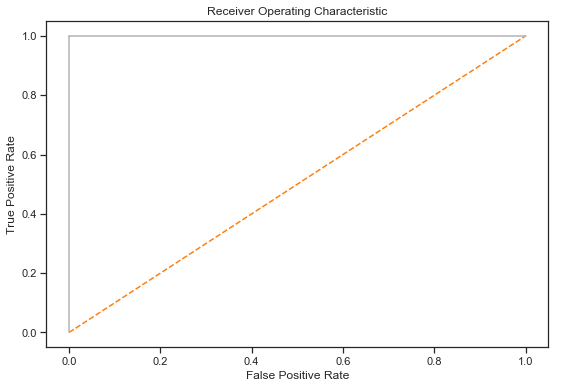

In [73]:
plot_roc_curve(y_test, y_score)

In [74]:
y_pred = clf_down.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5441
           1       0.00      0.00      0.00        18

   micro avg       1.00      1.00      1.00      5459
   macro avg       0.50      0.50      0.50      5459
weighted avg       0.99      1.00      1.00      5459



In [75]:
classifier_metric_report(clf_down, 'CLF Down', X_test, y_test)

,Precision,Recall,F1-Score,Specificity
CLF Down,0.0,0.996703,0.995057,1.0


Confusion matrix, without normalization


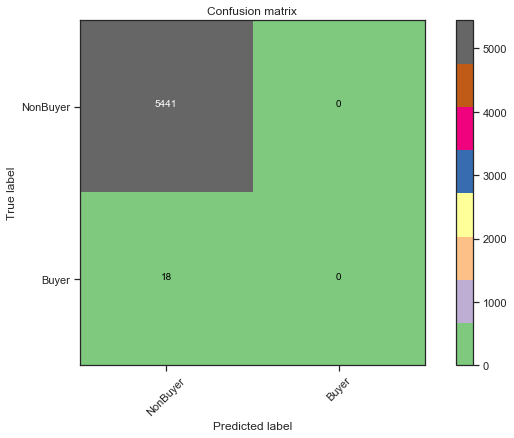

In [76]:
plot_confusion_matrix_with_labels(X_test, y_test, clf_down, predicted_class_names);

## Using SMOTE Sampling Methods <a name="SMOTE"></a>

In [77]:
df2 = df.drop(columns = ['multiple_buy', 'multiple_visit',
                       'expected_time_buy','expected_time_visit'])
X = df2[df2.columns[:-1]]
y = df2['y_buy']

In [78]:
X.shape

(54584, 9)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### ADASYN  <a name="ADASYN"></a>

In [80]:
X_sampled, y_sampled = create_balanced_dataset('ADASYN', X_train, y_train)

X=(49125, 9), y=[(0, 48890), (1, 235)]
X_sampled=(97749, 9), y_sampled=[(0, 48890), (1, 48859)]


In [81]:
# Create classifier
clf_smote = LogisticRegression()

# Train model
clf_smote.fit(X_sampled, y_sampled)

# Get predicted probabilities
y_score = clf_smote.predict_proba(X_test)[:,1]

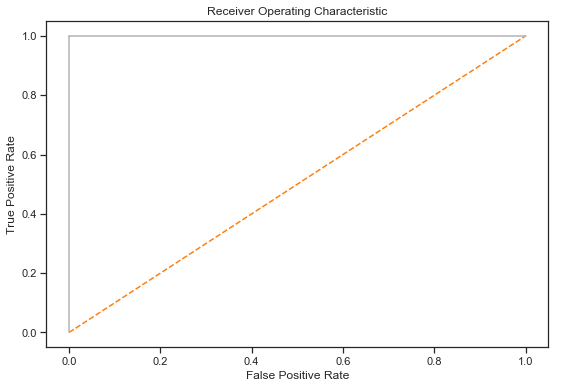

In [82]:
plot_roc_curve(y_test, y_score)

In [83]:
y_pred = clf_smote.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5441
           1       0.00      0.00      0.00        18

   micro avg       1.00      1.00      1.00      5459
   macro avg       0.50      0.50      0.50      5459
weighted avg       0.99      1.00      0.99      5459



In [88]:
classifier_metric_report(clf_smote, 'CLF ADASYN', X_test, y_test)

,Precision,Recall,F1-Score,Specificity
CLF ADASYN,0.0,0.99652,0.994965,0.999816


Confusion matrix, without normalization


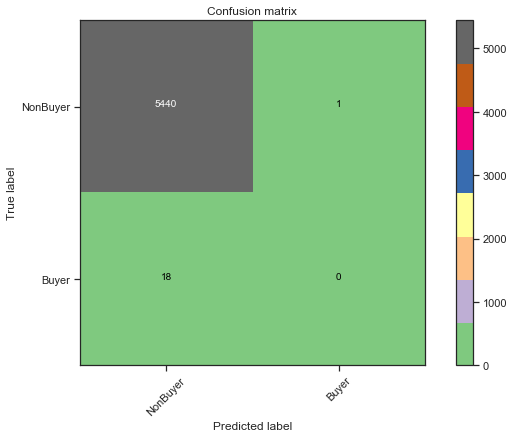

In [89]:
plot_confusion_matrix_with_labels(X_test, y_test, clf_smote, predicted_class_names);

### SMOTE <a name="SMOTE"></a>

In [90]:
X_sampled, y_sampled = create_balanced_dataset('SMOTE', X_train, y_train)

X=(49125, 9), y=[(0, 48890), (1, 235)]
X_sampled=(97780, 9), y_sampled=[(0, 48890), (1, 48890)]


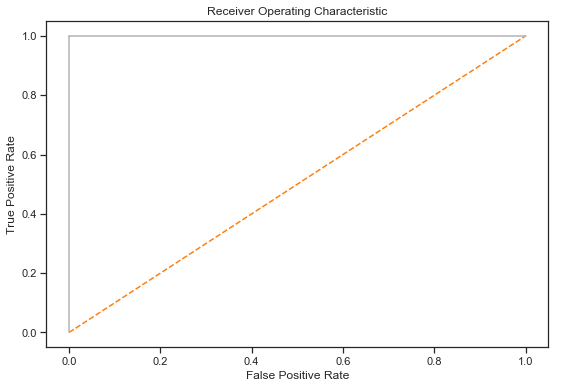

In [91]:
# Create classifier
clf_smote = LogisticRegression()

# Train model
clf_smote.fit(X_sampled, y_sampled)

# Get predicted probabilities
y_score = clf_smote.predict_proba(X_test)[:,1]
plot_roc_curve(y_test, y_score)

In [92]:
y_pred = clf_smote.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5441
           1       0.00      0.00      0.00        18

   micro avg       1.00      1.00      1.00      5459
   macro avg       0.50      0.50      0.50      5459
weighted avg       0.99      1.00      0.99      5459



In [93]:
classifier_metric_report(clf_smote, 'CLF SMOTE', X_test, y_test)

,Precision,Recall,F1-Score,Specificity
CLF SMOTE,0.0,0.99652,0.994965,0.999816


Confusion matrix, without normalization


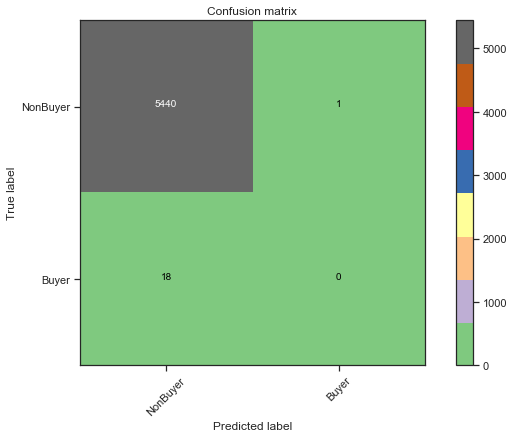

In [94]:
plot_confusion_matrix_with_labels(X_test, y_test, clf_smote, predicted_class_names);

## Modeling With Balanced Data Set <a name="ModelingBalDataSet"></a>
With the data set balanced using SMOTE, let's reuse the same ensemble models.

### Modeling With Ensemble Classifiers Including Classifiers With Balancing Samplers <a name="BalDataEnsModels"></a>

In [95]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_sampled, y_sampled); 

In [96]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                #sampling_strategy='auto',
                replacement=False,
        random_state=0)
bbc.fit(X_sampled, y_sampled); 

In [97]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_sampled, y_sampled);

In [98]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_sampled, y_sampled);

In [99]:
labels=['RandomForest', 'BalancedBaggingClassifier', 'BalancedRandomForestClassifier', 'LinearDiscriminantAnalysis']
models=[rf, bbc, brf, lda]
scores = np.zeros((len(y_test), len(labels)))
for i, model in enumerate(models):
    scores[:,i] = model.predict_proba(X_test)[:,1]   

results = classifiers_metric_report(models, labels, X_test, y_test)
results.round(3)

,Precision,Recall,F1-Score,Specificity
RandomForest,0.077,0.995,0.994,0.998
BalancedBaggingClassifier,0.037,0.992,0.993,0.995
BalancedRandomForestClassifier,0.000,0.994,0.994,0.997
LinearDiscriminantAnalysis,0.013,0.805,0.889,0.805


As expected with a balanced dataset, we should not observe significant differences in performance between 
balanced and "non-balanced" classifiers, 
this is the case for example for random forest vs. balanced random forest classifiers.

In [100]:
y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      5441
           1       0.01      0.78      0.03        18

   micro avg       0.80      0.80      0.80      5459
   macro avg       0.51      0.79      0.46      5459
weighted avg       1.00      0.80      0.89      5459



In [101]:
classifier_metric_report(lda, 'LDA CLF', X_test, y_test)

,Precision,Recall,F1-Score,Specificity
LDA CLF,0.013011,0.804726,0.888635,0.804815


Confusion matrix, without normalization


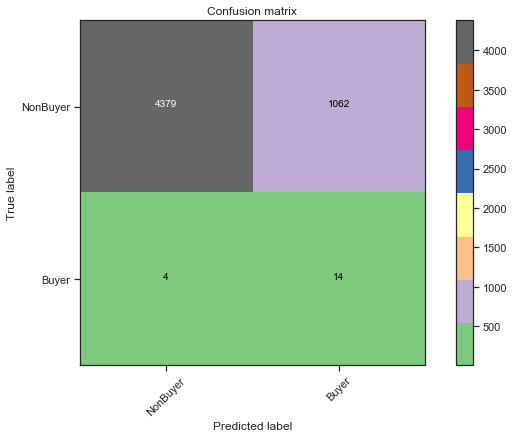

In [102]:
plot_confusion_matrix_with_labels(X_test, y_test, lda, predicted_class_names);

# Most Important Features <a name="MostImportantFeatures"></a>

In [103]:
feature_names = list(df2.columns.values)[:-1]
print(feature_names)

['isbuyer', 'buy_freq', 'visit_freq', 'buy_interval', 'sv_interval', 'last_buy', 'last_visit', 'uniq_urls', 'num_checkins']


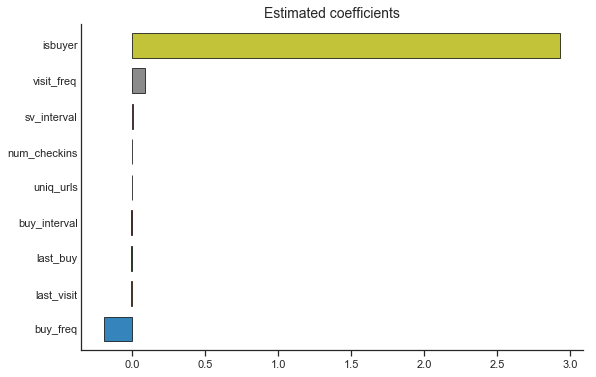

In [104]:
plot_coefficients(lda, feature_names);